In [2]:
from keras.layers import Input, Dense, Embedding, Flatten, Dropout, Convolution1D, MaxPooling1D, concatenate
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
import keras.preprocessing.text
from keras.utils.np_utils import to_categorical
import NLP_utils
import numpy as np
import pickle as pickle

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt

# Classifying SEC filings.

Today, I'm going to do a quick and dirty project to prove out feasibility of using neural networks to classify legal documents.  There's a great dataset available publicly on the SEC's website.  I wrote a scraper, which you can find here: https://github.com/javedqadruddin/EDGAR that can download large numbers of different types of SEC filings.  For this experiment, I grabbed a sample of about 4000 documents each of 10-K, 10-Q, and 8-K filings (for those interested, these are filings that all public companies must make with the SEC periodically).

In [4]:
data_path = 'data/real'
MAX_SEQUENCE_LENGTH = 1000

### Grabbing samples

These files are really big, so it'll take forever to run a ML model on whole files, and, even if we wanted to, we'd have to find a way around the fact that they won't all fit in memory.  Instead of using whole files, we'll just grab the first 1000 words of each.  The first 1000 words should be more than enough text to be able to distinguish these types of documents from each other.  A human can certainly distinguish them within the first 1000 words.. we'll see now whether we can train a computer to do it.  This handy utility I wrote grabs the data and labels each datapoint appropriately.

In [14]:
(texts, labels_index, labels) = NLP_utils.get_labelled_data_from_directories(data_path, MAX_SEQUENCE_LENGTH)

In [ ]:
texts[:10]

### Tokenization

Our first step will be to take our samples of 1000 words from each document and turn each of them into a sequence of 1000 numbers that represent the words.  Those numbers will stand for the word and, later on, will point us to a vectorized representation of the word they stand for.  A tokenizer goes through a body of text and assigns a number to each unique 'word' it finds.  Generally, tokenizers will assign numbers to punctuation marks as well. We're using a filter here to tell it to simply ignore puctuation certain puctuation marks that we don't think are important to our task.

In [15]:
tokenizer = Tokenizer(num_words=10000, filters=NLP_utils.filter_not_punctuation())
tokenizer.fit_on_texts(texts)

In [16]:
sequences = tokenizer.texts_to_sequences(texts)
sequences[0][:10]

[238, 232, 229, 230, 253, 56, 254, 249, 126, 29]

The tokenizer labelled every single unique word with a number, and there were several hundred thousand unique words in the corpus.  Having that many unique words to learn about, most of which only appear in the corpus only once, will increase the complexity of our model and probably make our results worse. So, we will simplify things by making every word with a number > 10000 equal to 10000. The tokenizer very helpfully assigns the numbers in the order from most common word to least common, so everything with a number over 10000 probably only appears once or a handful of times. We will just set them all to 10000 so that the number 10000 will be interpreted by the model to simply mean 'rare word here'.

In [ ]:
#contstraining vocab to 10000
for sequence in sequences:
    sequence = [10000 for num in sequence if num > 10000]
sequences[0][:10]

To make sure all our inputs are of the same size, we pad them, since, theoretically, some of them could have been less than 1000 words long.

In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
data.shape[0]
np.arange(data.shape[0])

### Splitting train and validation data

Next we break the data into training sets and validation sets. The model will only see the training set while training, so the validation set will be able to tell us how the model does on data it hasn't seen. It's important to shuffle the data when doing this because, if examples from each class are grouped together, the model will sequentially learn to always guess class 1 when it's looking at the class 1 data, then it'll re-train to guess class 2 when it gets shown only class 2 data, etc. 

In [ ]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

VALIDATION_SPLIT = .2
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [ ]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
# saving the training data so it can be used again without going through the whole process above
training_vector_save_path = 'data/training_vectors/'
pickle.dump(x_train, open( training_vector_save_path + 'x_train.pk', "wb" ))
pickle.dump(y_train, open( training_vector_save_path + 'y_train.pk', "wb" ))
pickle.dump(x_val, open( training_vector_save_path + 'x_val.pk', "wb" ))
pickle.dump(y_val, open( training_vector_save_path + 'y_val.pk', "wb" ))

In [5]:
x_train = pickle.load(open("data/training_vectors/x_train.pk", "rb" ))
y_train = pickle.load(open("data/training_vectors/y_train.pk", "rb" ))
x_val = pickle.load(open("data/training_vectors/x_val.pk", "rb" ))
y_val = pickle.load(open("data/training_vectors/y_val.pk", "rb" ))

### Start Simple 

The first model is just an embedding layer with a single hidden dense layer. A little bit of dropout is added to protect against overfitting.  The embedding layer will learn a vectorized representation of each of the 10000 unique words we've given numbers to.  Each number will get a 32 dimensional vector to represent it.  The absolute positions of the words in the samples will be taken into account by the dense layer, along with their relative frequencies, but a dense layer will have quite a tough time learning to use small combinations of words that have meaning when they appear together in different places. 

In [5]:
model = Sequential([
    Embedding(10000, 32, input_length=MAX_SEQUENCE_LENGTH),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')])

In [6]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 32)          320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3200100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 3,520,403.0
Trainable params: 3,520,403.0
Non-trainable params: 0.0
_________________________________________________________________


In [7]:
model_history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=64, verbose=1)

Train on 9964 samples, validate on 2490 samples
Epoch 1/20
9964/9964 [==============================] - 5s - loss: 0.1110 - acc: 0.9585 - val_loss: 0.0185 - val_acc: 0.9952

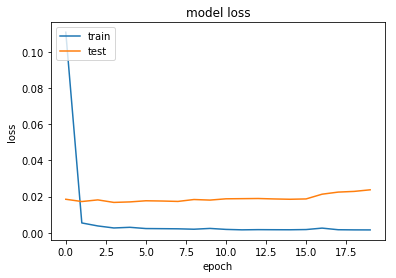

In [8]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results for the simple model

Ok, so it looks like our job is going to be pretty easy!  The simplest possible model we could use is already within four-tenths of a percent of perfect on the validation set.  It probably works well enough already and took less than 20 seconds to train. That's pretty awesome, but let's see if we can do better.  We'll save the weights on this network so we can use it again later if we want to.

In [ ]:
model_path = 'weights/'

In [ ]:
model.save_weights(model_path + '1_dense_20_epochs.h5')

### Using convolutions

Next we'll try a slightly more complex model. This model has 3 different size convolutions we'll apply to the raw input. Note, we are not stacking the convolutions on top of each other. We are instead applying 3 different convolutions with different sized filters to the raw input from the input layer. Essentially what this is doing is looking for useful bigrams, trigrams and 4-grams and then just serving them all up side-by-side to a later dense layer that'll make sense out of them. 

Acutally, that's a bit of a simplification--each conv finds a kind of bigram concept, trigram concept or 4-gram concept. The filter size 2 one isn't looking for specific bigrams, but rather each of its convs look for two-word sets that have a similar encoded meaning, kind of like 'good day' and 'good morrow'.

In [9]:
graph_in = Input ((10000, 32))
convs = [ ] 
for i in range (2, 5): 
    x = Convolution1D(64, i, padding='same', activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
out = Concatenate()(convs) 
graph = Model(graph_in, out) 
graph.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10000, 32)     0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 10000, 64)     4160                                         
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 10000, 64)     6208                                         
____________________________________________________________________________________________________
conv1d_3 (Conv1D)                (None, 10000, 64)     8256                                         
___________________________________________________________________________________________

In [10]:
three_convs_model = Sequential ([
    Embedding(10000, 32, input_length=MAX_SEQUENCE_LENGTH),
    Dropout (0.2),
    graph,
    Dropout (0.2),
    Dense (100, activation="relu"),
    Dropout (0.2),
    Dense (3, activation='softmax')
    ])

In [11]:
three_convs_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
three_convs_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 32)          320000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000, 32)          0         
_________________________________________________________________
model_1 (Model)              multiple                  18624     
_________________________________________________________________
dropout_3 (Dropout)          (None, 96000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               9600100   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total para

In [12]:
three_convs_history = three_convs_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32, verbose=1)

Train on 9964 samples, validate on 2490 samples
Epoch 1/10
9964/9964 [==============================] - 14s - loss: 0.1077 - acc: 0.9548 - val_loss: 0.0167 - val_acc: 0.9952

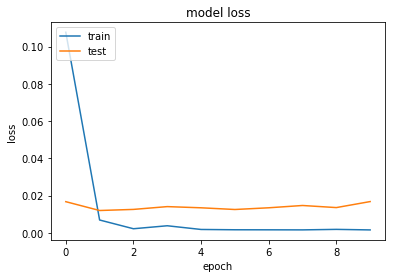

In [13]:
plt.plot(three_convs_history.history['loss'])
plt.plot(three_convs_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So it looks like a more complex model does help somewhat. It's beating the 1-dense-layer model already after only 10 epochs.

In [ ]:
three_convs_model.save_weights(model_path + '3_convs_10_epochs.h5')

In [14]:
three_convs_model.optimizer.lr=0.0001

Further training on this more complex model doesn't seem to improve things much.. it seems to have converged.

In [15]:
three_convs_history = three_convs_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32, verbose=1)

Train on 9964 samples, validate on 2490 samples
Epoch 1/10
9964/9964 [==============================] - 14s - loss: 0.0016 - acc: 0.9993 - val_loss: 0.0157 - val_acc: 0.9964

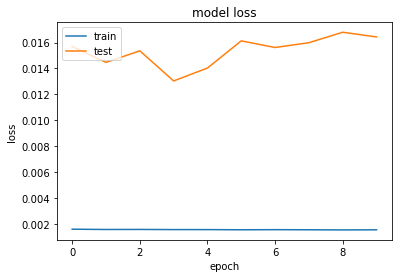

In [16]:
plt.plot(three_convs_history.history['loss'])
plt.plot(three_convs_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results of the 3-conv model

The validation set results beat the simpler model by 0.3%. So, even with very little room for improvement, the more complex model does improve results. It was able to correctly classify roughly half of the last few difficult examples that the simpler model couldn't get, and it was able to do it after fewer epochs of training.

Let's see if we can do even better. Next I'll create a model similar to the conv model except that the input tensor gets fed to the dense layer along with the conv layers.  The prior model might have lost some important details about individual words by getting all of its information filtered through the convs.  This approach should avoid losing that single-word-level detail.

In [17]:
input_tensor = Input ((10000, 32))
convs = [] 
for num in range (2, 5): 
    x = Convolution1D(64, num, padding='same', activation="relu")(input_tensor)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)

conv_out = Concatenate()(convs)
shortcut = Flatten()(input_tensor)
full_out = Concatenate()([conv_out, shortcut])

graph = Model(input_tensor, full_out) 
graph.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 10000, 32)     0                                            
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 10000, 64)     4160                                         
____________________________________________________________________________________________________
conv1d_5 (Conv1D)                (None, 10000, 64)     6208                                         
____________________________________________________________________________________________________
conv1d_6 (Conv1D)                (None, 10000, 64)     8256                                         
___________________________________________________________________________________________

In [18]:
three_convs_w_shortcut_model = Sequential ([
    Embedding(10000, 32, input_length=MAX_SEQUENCE_LENGTH),
    Dropout (0.2),
    graph,
    Dropout (0.2),
    Dense (100, activation="relu"),
    Dropout (0.2),
    Dense (3, activation='softmax')
    ])

In [19]:
three_convs_w_shortcut_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
three_convs_w_shortcut_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 32)          320000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000, 32)          0         
_________________________________________________________________
model_2 (Model)              multiple                  18624     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               12800100  
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total para

In [20]:
three_conv_w_shortcut_history = three_convs_w_shortcut_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32, verbose=1)

Train on 9964 samples, validate on 2490 samples
Epoch 1/10
9964/9964 [==============================] - 17s - loss: 0.0769 - acc: 0.9698 - val_loss: 0.0110 - val_acc: 0.9960

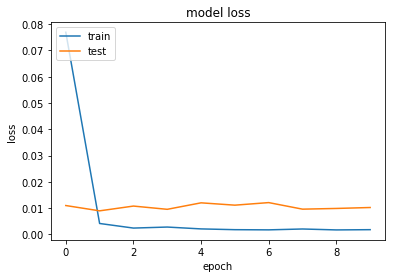

In [21]:
plt.plot(three_conv_w_shortcut_history.history['loss'])
plt.plot(three_conv_w_shortcut_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

No improvement over the conv model, maybe slightly worse... let's try another 10 epochs just to see

In [23]:
three_conv_w_shortcut_history_2 = three_convs_w_shortcut_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32, verbose=1)

Train on 9964 samples, validate on 2490 samples
Epoch 1/10
9964/9964 [==============================] - 16s - loss: 0.0016 - acc: 0.9993 - val_loss: 0.0106 - val_acc: 0.9968

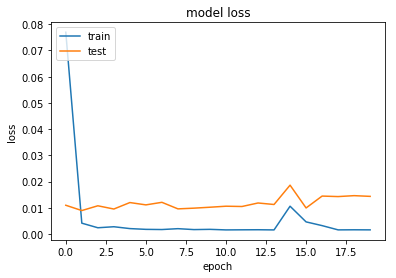

In [35]:
plt.plot(three_conv_w_shortcut_history.history['loss'] + three_conv_w_shortcut_history_2.history['loss'])
plt.plot(three_conv_w_shortcut_history.history['val_loss'] + three_conv_w_shortcut_history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results of the 3-conv-with-shortcut model

It seems that feeding the input layer directly to the dense layer along with the output of the conv layers doesn't really improve things.  Interesting.  It would be cool to see if this shortcut idea works better on other datasets--perhaps ones where we aren't already doing so well.

What else can we try to make it better?  We're reducing the number of parameters quite precipitously at the end by going straight to a 100 neuron dense layer. Perhaps a bigger dense layer first, then 100, then 3 will work better. Let's try it.

In [6]:
input_tensor = Input ((10000, 32))
convs = [] 
for num in range (2, 5): 
    x = Convolution1D(64, num, padding='same', activation="relu")(input_tensor)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)

conv_out = Concatenate()(convs)
shortcut = Flatten()(input_tensor)
full_out = Concatenate()([conv_out, shortcut])

graph_2 = Model(input_tensor, full_out) 
graph_2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10000, 32)     0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 10000, 64)     4160                                         
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 10000, 64)     6208                                         
____________________________________________________________________________________________________
conv1d_3 (Conv1D)                (None, 10000, 64)     8256                                         
___________________________________________________________________________________________

In [7]:
three_convs_w_shortcut_model_2_dense = Sequential ([
    Embedding(10000, 32, input_length=MAX_SEQUENCE_LENGTH),
    Dropout (0.2),
    graph_2,
    Dropout (0.2),
    Dense (200, activation="relu"),
    Dropout (0.2),
    Dense (100, activation="relu"),
    Dropout (0.2),
    Dense (3, activation='softmax')
    ])

In [8]:
three_convs_w_shortcut_model_2_dense.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
three_convs_w_shortcut_model_2_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 32)          320000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 32)          0         
_________________________________________________________________
model_1 (Model)              multiple                  18624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               25600200  
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
__________

In [9]:
three_convs_w_shortcut_2_dense_history = three_convs_w_shortcut_model_2_dense.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64, verbose=1)

Train on 9964 samples, validate on 2490 samples
Epoch 1/10
9964/9964 [==============================] - 17s - loss: 0.1150 - acc: 0.9573 - val_loss: 0.0175 - val_acc: 0.9952

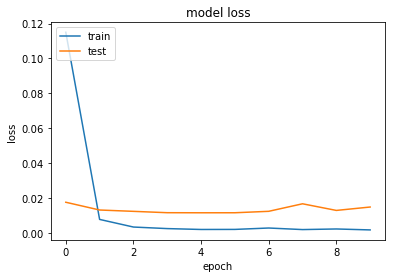

In [10]:
plt.plot(three_convs_w_shortcut_2_dense_history.history['loss'])
plt.plot(three_convs_w_shortcut_2_dense_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Seems like that didn't really work. The same-ish performance.  :-/

### Using pre-trained embeddings

People with access to a helluva lot more data than me, and racks upon racks of GPUs have already trained word vectors on various corpora of text. The text they've trained on are in general domains, rather than our specific problem, but those embeddings contain excellent information on the relationships between Enlgish words.  I'm going to try something here that I haven't seen or tried before: I'll use the pre-trained embeddings in addition to our own embeddings.  This way, we should get the benefit of the pre-trained embeddings' information about what a word means from a huge training set, while also getting the nuance of what a word means in the context of the problem we're trying to solve.  Let's see if it works.

In [12]:
# http://nlp.stanford.edu/data/glove.6B.zip
embeddings_index = {}
f = open('glove/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [17]:
word_index = tokenizer.word_index
truncated_word_index = {key: value for key, value in word_index.items() if value < 10000}
print(len(truncated_word_index))
glove_embedding_dimension = 50
embedding_matrix = np.zeros((len(truncated_word_index) + 1, glove_embedding_dimension))
for word, i in truncated_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

9999


In [18]:
glove_embedding_layer = Embedding(len(word_index) + 1,
                            glove_embedding_dimension,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [19]:
input_tensor = Input(shape=(1000,), dtype='int32', name='main_input')

embedding_layer = Embedding(10000, 32, input_length=1000, name='main_embedding')(input_tensor)
embedding_layer = Dropout(0.2)(embedding_layer)

glove_embedding_layer = Embedding(10000, 50, input_length=1000, name='glove_embedding', weights=[embedding_matrix], trainable=False)(input_tensor)
glove_embedding_layer = Dropout(0.2)(glove_embedding_layer)

convs = [] 
for num in range (2, 5): 
    x = Convolution1D(64, num, padding='same', activation="relu")(embedding_layer)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)

for num in range (2, 5): 
    x = Convolution1D(64, num, padding='same', activation="relu")(glove_embedding_layer)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)

conv_out = Concatenate(name='concatenated_convs')(convs)
shortcut = Flatten(name='shortcut_main_embedding')(embedding_layer)
dense_in = Concatenate(name='concat_main_embedding_plus_convs')([conv_out, shortcut])

nex = Dropout(0.2)(dense_in)
nex = Dense(100, activation="relu", name='dense_consolidator')(nex)
nex = Dropout(0.2)(nex)
full_out = Dense (3, activation='softmax', name='final_output')(nex)

shortcut_glove_model = Model(input_tensor, full_out) 
shortcut_glove_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 1000)          0                                            
____________________________________________________________________________________________________
main_embedding (Embedding)       (None, 1000, 32)      320000                                       
____________________________________________________________________________________________________
glove_embedding (Embedding)      (None, 1000, 50)      500000                                       
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 1000, 32)      0                                            
___________________________________________________________________________________________

In [20]:
shortcut_glove_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [21]:
shortcut_glove_model_history = shortcut_glove_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=64, verbose=1)

Train on 9964 samples, validate on 2490 samples
Epoch 1/1
9964/9964 [==============================] - 21s - loss: 0.3935 - acc: 0.9008 - val_loss: 0.0228 - val_acc: 0.9920

In [22]:
shortcut_glove_model_history_2 = shortcut_glove_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32, verbose=1)

Train on 9964 samples, validate on 2490 samples
Epoch 1/10
9964/9964 [==============================] - 30s - loss: 0.0109 - acc: 0.9965 - val_loss: 0.0175 - val_acc: 0.9944

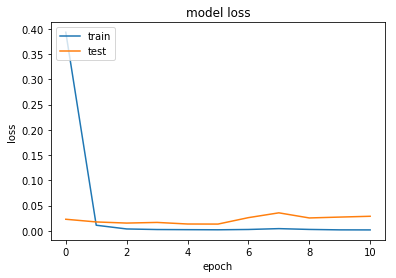

In [23]:
plt.plot(shortcut_glove_model_history.history['loss'] + shortcut_glove_model_history_2.history['loss'])
plt.plot(shortcut_glove_model_history.history['val_loss'] + shortcut_glove_model_history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Not much better than before, bummer. And looks like we could be overfitting slightly, but let's save weights and try another 10 epochs and see what happens.

In [ ]:
shortcut_glove_model.save_weights(model_path + 'shortcut_glove_10_epochs.h5')

In [24]:
shortcut_glove_model_history_3 = shortcut_glove_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64, verbose=1)

Train on 9964 samples, validate on 2490 samples
Epoch 1/10
9964/9964 [==============================] - 20s - loss: 0.0016 - acc: 0.9993 - val_loss: 0.0292 - val_acc: 0.9944

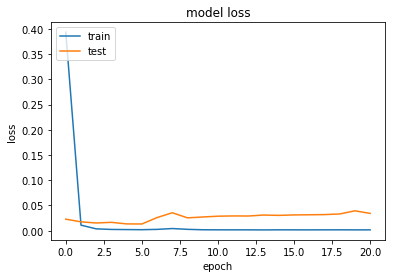

In [25]:
plt.plot(shortcut_glove_model_history.history['loss'] + shortcut_glove_model_history_2.history['loss'] + shortcut_glove_model_history_3.history['loss'])
plt.plot(shortcut_glove_model_history.history['val_loss'] + shortcut_glove_model_history_2.history['val_loss'] + shortcut_glove_model_history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Awesome! So not a whole ton of difference, but, all-in-all, this seems to be doing quite well--over 99% accuracy.  Cool!  Time to save weights and call it a day.

In [ ]:
shortcut_glove_model.save_weights(model_path + 'shortcut_glove_20_epochs.h5')

# Conclusions

It seems that classifying SEC filings is really easy with neural networks.  None of these approaches is particularly complex or difficult to implement, and we achieved a result that gets within two-tenths of a percent of perfect on the validation set.  That is pretty damn good. Depending on how fast you need your classifications to run, you might want to use one of the simpler models here rather than the shortcut_glove_model because the simpler ones will run faster. 

So, I'd say this proof-of-concept is a success: it's probably quite easy to use deep learning to classify contracts, filings and other similar legal documents. Yay!

Other things to try: using a 10,000 word vocabulary may be overkill.  We might actually get better generalization to unseen data if we reduce the vocabulary size, since things the model learns about words that appear only once or a handful of times can't be fully trusted to generalize well when we see that word again outside the training data. 